In [6]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader

#%load_ext line_profiler

In [7]:
from model.eGauss_plus import eGAUSSp

In [8]:
# Load the dataset
file_path = 'Datasets/creditcard.csv'
data = pd.read_csv(file_path)


In [9]:
from utils.utils_dataset import balance_dataset
from utils.utils_dataset import prepare_dataset

device = torch.device("cpu")
num_clients = 4

proportion = 100
#data = balance_dataset(data, proportion)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
client_train, test_data, all_data = prepare_dataset(X, y, num_clients) 


In [10]:

# Model parameters
local_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "N_max": 1,
    "num_sigma": 2,
    "kappa_join": 1,
    "S_0": 1e-8,
    "c_max": 2,
    "device": device
}

federated_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "N_max": 1,
    "num_sigma": 2,
    "kappa_join": 1.5,
    "S_0": 1e-8,
    "c_max": 2,
    "device": device
}

# Initialize a model for each client
local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
federated_model = eGAUSSp(**federated_model_params)


Client 1: {0: 49761, 1: 80}
Client 2: {0: 49746, 1: 95}
Client 3: {0: 49760, 1: 81}
Client 4: {0: 49757, 1: 84}
Test Set: {0: 85291, 1: 152}

Combined Number of Samples per Class:
Class 0: 284315 samples
Class 1: 492 samples

Total Number of Samples Across All Datasets: 284807


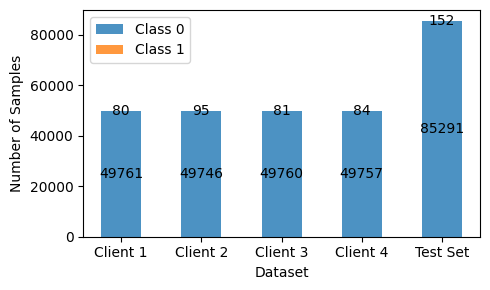

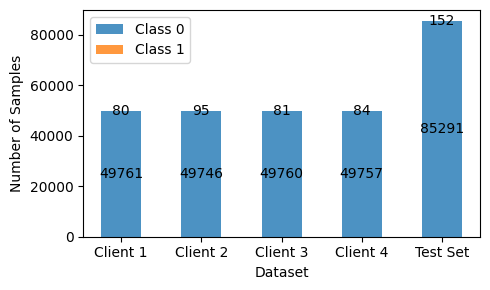

In [11]:
from utils.utils_dataset import prepare_non_iid_dataset, plot_dataset_split, display_dataset_split

display_dataset_split(client_train, test_data)
plot_dataset_split(client_train, test_data)

In [12]:
import utils.utils_train
from utils.utils_train import train_supervised, calculate_metrics, plot_confusion_matrix, calculate_roc_auc
from utils.utils_plots import plot_first_feature
import cProfile
%load_ext line_profiler

if False:


    # Assuming models and client_data are already defined
    #for client_idx, client_model in enumerate(local_models):
    
    data, labels = client_train[0]
    
    model = local_models[0]
    pr = cProfile.Profile()
    pr.enable()
    train_supervised(model, client_train[0])
    pr.disable()
    pr.print_stats(sort='cumtime')

#plot_first_feature(client_train[client_idx], model=client_model, num_sigma=2, N_max=1)  



In [13]:
if False:
       data, labels = client_train[0]
       model = local_models[0]

       %lprun -f model.forward\
              -f model.merging_mech.compute_kappa_matrix \
              -f model.merging_mech.merging_mechanism \
              -f model.merging_mech.update_merging_condition \
              -f model.merging_mech.compute_merging_condition\
              -f model.merging_mech.perform_merge\
              train_supervised(model, client_train[0])

In [14]:
import utils.utils_train
from utils.utils_train import train_models_in_threads
from utils.utils_plots import plot_first_feature

# Assuming local_models and client_train are already defined
# local_models is a list of models, client_train is a list of corresponding training datasets
train_models_in_threads(local_models, client_train)


Evolving has been enabled.
Evolving has been enabled.
Evolving has been enabled.
Evolving has been enabled.


In [ ]:
from utils.utils_train import test_model   

# Testing each client's model on the global test dataset
if False:
    for client_idx, client_model in enumerate(local_models):
        print(f"\nTesting model for client {client_idx + 1}")
        all_scores, pred_max = test_model(client_model, test_data)
        metrics = calculate_metrics(pred_max, test_data)
        #test_model(client_model, all_data)
        print(f"Test Metrics: {metrics}")
        
    

In [ ]:

for client_idx, client_model in enumerate(local_models):
        print(f"Merging client {client_idx + 1}")
        client_model.federal_agent.federated_merging() 
        print(f"Number of client {client_idx + 1} clusters = {torch.sum(client_model.n[:client_model.c]>1)}")
        federated_model.federal_agent.merge_model_privately(client_model, 1)

print(f"Number of clusters after transfer = {federated_model.c}")

In [ ]:
from utils.utils_train import test_model

federated_model.federal_agent.federated_merging()
print(f"Number of clusters after merging = {federated_model.c}")


In [ ]:

plot_first_feature(all_data, model=federated_model, num_sigma=federated_model.num_sigma, N_max=1)   

print(f"\nTesting federated model")   

all_scores, pred_max = test_model(federated_model, test_data)
metrics = calculate_metrics(pred_max, test_data)
print(f"Test Metrics: {metrics}")
roc_auc = calculate_roc_auc(all_scores, test_data)
test_model(client_model, all_data)
print(f"Test ROC AUC: {roc_auc}")
test_model(federated_model, all_data)


plot_confusion_matrix(pred_max, test_data)